# Beiwe-visualizer

In [1]:
import os, sys
# Please specify data file path here:
# folder hierarchy: main-path/study-name/user-name/feature-name/[timestamp-sortable].csv or main-path/study-name/user-name/feature-name.csv.gz
# os.main_path = os.getenv('HOME')+''
os.main_path = os.getenv('HOME')+'/projects/beiwe-gitlab/beiwe-visualizer/3.decrypted/'

# disable autosave so that multiple user browser can attach the same notebook
%autosave 0

# enable notebook mode so that we can drag, resize and save plots
%matplotlib notebook

from core import *

Autosave disabled


<IPython.core.display.Javascript object>

In [2]:
HBox([dropdown_studies, fileupload])

# Clinician Dashboard

In [3]:
def group_dates(data, labels, figsize):
    periods = [(s+'D' if s.isdigit() else s) for s in re.split('[ ,;]+', os.DateGroup)]
    index = data.index if type(data.index) == pd.DatetimeIndex else data.datetime
    max_date = index.max().floor('D')
    cut_points = [max_date]
    for period in periods[::-1]:
        max_date -= pd.to_timedelta(period)
        cut_points = [max_date] + cut_points
    dfg = data.groupby(pd.cut(index, cut_points, right=False))
    figsize[0] = len(periods)*0.4
    if index.nunique()==len(data):
        ret = dfg.mean()
        ret_index = ret.index
    else:
        ret = pd.concat([set_index_to_value(v.reset_index(drop=True), k, 'datetime') for k,v in dfg], ignore_index=True)
        ret_index = [k for k,v in dfg]
    return ret, ret_index, figsize

def calc_exchange(v):
    return set(v[v['type']=='received SMS'].contact) & set(v[v['type']=='sent SMS'].contact)

def drawAll(Username, StartDate, LastDate, DateGroup, DoPlot):
    if not DoPlot: return clear_output()
    
    PP = None
    if DateGroup:
        os.DateGroup = DateGroup
        PP = group_dates
    
    # init parameters
    file_suffix = '.csv.gz'
    xticklabels=['previous month', 'previous week', 'current week']
    plt.switch_backend('module://ipykernel.pylab.backend_inline')
    
    # arrange into horizontal grid
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[12,4])
    plt.subplots_adjust(wspace = 0.5)
    
    
    ## 1. sleep
    df = filter_by_date(load_df(Username, 'sleep'+file_suffix, verbose=-1), StartDate, LastDate).sort_index()
    if len(df)==0:
        display(HTML('<font color=red>Warning: sleep data is absent!</font>'))
    else:
        df = df[df.Level!='main']
        df.Seconds /= 3600
        # get sleep efficiency
        sleep_efficiency = df.groupby(pd.Grouper(freq='1D', base=0.5))['Efficiency'].mean()
        SE, SE_index, SE_figsize = group_dates(sleep_efficiency, None, [16,9])
        clist = [(0, "red"), (0.5, "orange"), (1, "green")]
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", clist)
        # plot sleep duration together with sleep efficiency
        plot1 = draw(df, None, None, 0.0, False, None, 'sum in each interval', '1D', 0.5, 0, 'time chart (bar)', 'Seconds', 'mean',
                     '<entry-count>', False, 'no sort', False, False, False, False, None, verbose=-1, post_processor=PP, ax=axs[0], plot_options={'color':[cmap(SE/100)], 'legend':None},
                     set_title='Sleep', set_ylabel='Sleep Duration (hours)', set_xticklabels=xticklabels)
        cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap), ax=plot1)
        cbar.set_label('Sleep Efficiency')
    
    
    ## 2. sociability
    # 2.1a whatsapp calls
    df1a = filter_by_date(load_df(Username, 'sociabilityCallLog'+file_suffix, verbose=-1), StartDate, LastDate).sort_index()
    df1a = pd.DataFrame() if len(df1a)==0 else pd.concat([pd.DataFrame({'app':v.app[0], 'contact':v.contact[0], 'call type':('Incoming Call' if v.eventType[0]==1 else 'Outgoing Call'),
           'recordedDuration':v.recordedDuration[-1]}, index=[v.index[0]]) for k,v in df1a.groupby('sessionId')])
    # 2.1b phone calls
    df1b = filter_by_date(load_df(Username, 'callLog'+file_suffix, verbose=-1), StartDate, LastDate)\
        .rename(columns={'duration in seconds':'recordedDuration', 'hashed phone number':'contact'}).sort_index()
    df1b = pd.DataFrame() if len(df1b)==0 else set_index_to_value(df1b, 'phone', col='app')[['app', 'contact', 'call type', 'recordedDuration']]
    # merged DataFrame for both types of calls
    df1 = pd.concat([df1a, df1b]).rename(columns={'call type':'type'}).sort_index()
    # 2.2a phone SMS
    df2a = filter_by_date(load_df(Username, 'textsLog'+file_suffix, verbose=-1), StartDate, LastDate).sort_index()
    df2a['app'] = 'phone'
    df2a = pd.DataFrame() if len(df2a)==0 else df2a.rename(columns={'hashed phone number':'contact', 'sent vs received':'type', 'message length':'msgLength'})[['app', 'contact', 'type', 'msgLength']]
    # 2.2b WhatsApp message
    df2b = filter_by_date(load_df(Username, 'sociabilityLog'+file_suffix, verbose=-1), StartDate, LastDate).sort_index()
    if len(df2b)>0:
        df2b = df2b[['app', 'contact', 'orientation', 'length']].rename(columns={'orientation':'type', 'length':'msgLength'})
        df2b.type = df2b.type.apply(lambda x: 'sent SMS' if x==0 else 'received SMS')
    df = pd.concat([df1, df2a, df2b], sort=False).sort_index()
    if len(df)==0:
        display(HTML('<font color=red>Warning: sociability data is absent!</font>'))
    else:
        dfg_calls = df.groupby(pd.Grouper(freq='1D'))
        out = [[len(v[v.recordedDuration>=60]), len(calc_exchange(v))] for k,v in dfg_calls]
        df = pd.DataFrame(out, index=[k for k,v in dfg_calls], columns=['n_calls>1min', 'n_exchange_msg'])
        plot2 = draw(df, None, None, 0.0, False, None, 'pass through all', '1D', 0, 0, 'time chart stacked bar', ['n_exchange_msg', 'n_calls>1min'], 0,
                '<entry-count>', False, 'no sort', False, False, False, False, None, verbose=-1, post_processor=PP, ax=axs[1], set_title='Sociability', set_xticklabels=xticklabels)
        lhs, lls = plot2.get_legend_handles_labels()
        plot2.legend(lhs[::-1], lls[::-1])
    
    
    ## 3. mobility
    df1 = load_df(Username, 'gps-mobility'+file_suffix, verbose=-1)
    if len(df1)==0:
        display(HTML('<font color=red>Warning: mobility data is absent!</font>'))
    else:
        df1 = filter_by_date(df1[['Hometime', 'RoG']], StartDate, LastDate).sort_index()
        df = (24-df1[['Hometime']]/60).rename(columns={'Hometime':'TAFH'})
        # prepare RoG
        RoG, _, _ = group_dates(np.log10(df1[['RoG']].clip(0, np.inf)+1), None, [16,9])
        RoG = [10**v for v in RoG.RoG]
        def cmap(val):
            if val<100:
                return 'red'
            elif val>1000:
                return 'green'
            return 'orange'
        
        # plot time-away-from-home together with RoG
        os.plot3 = plot3 = draw(df, None, None, 0.0, False, None, 'mean value in each interval', '1D', 0, 0, 'time chart (bar)', 'TAFH', 10,
                     '<entry-count>', True, 'no sort', False, False, False, False, None, verbose=-1, post_processor=PP, ax=axs[2], plot_options={'color':[[cmap(v) for v in RoG]]},
                     set_title='Mobility', set_ylabel='Daily Time Away From Home (hours)', set_xticklabels=xticklabels)
        plot3.legend(handles=[Patch(color='green', label='>1km'), Patch(color='orange', label='100m-1km'), Patch(color='red', label='<100m')], title='Radius of Gyration')

    
date_group1 = Text(value='30 7 7', placeholder='Input date group such as "30 7 7"', disabled=False)
W1 = interactive(drawAll, Username = dropdown_userlist, StartDate = DatePicker(value=None), LastDate = DatePicker(value=None), DateGroup = date_group1, DoPlot = ToggleButton(value=False, description='Update Plot'))
VBox([HBox(W1.children[0:-1]), W1.children[-1]])

# Padding (Jupyter notebook UI has a bug that if the following is removed, the UI will scroll upon every interactive click)

<IPython.core.display.Javascript object>


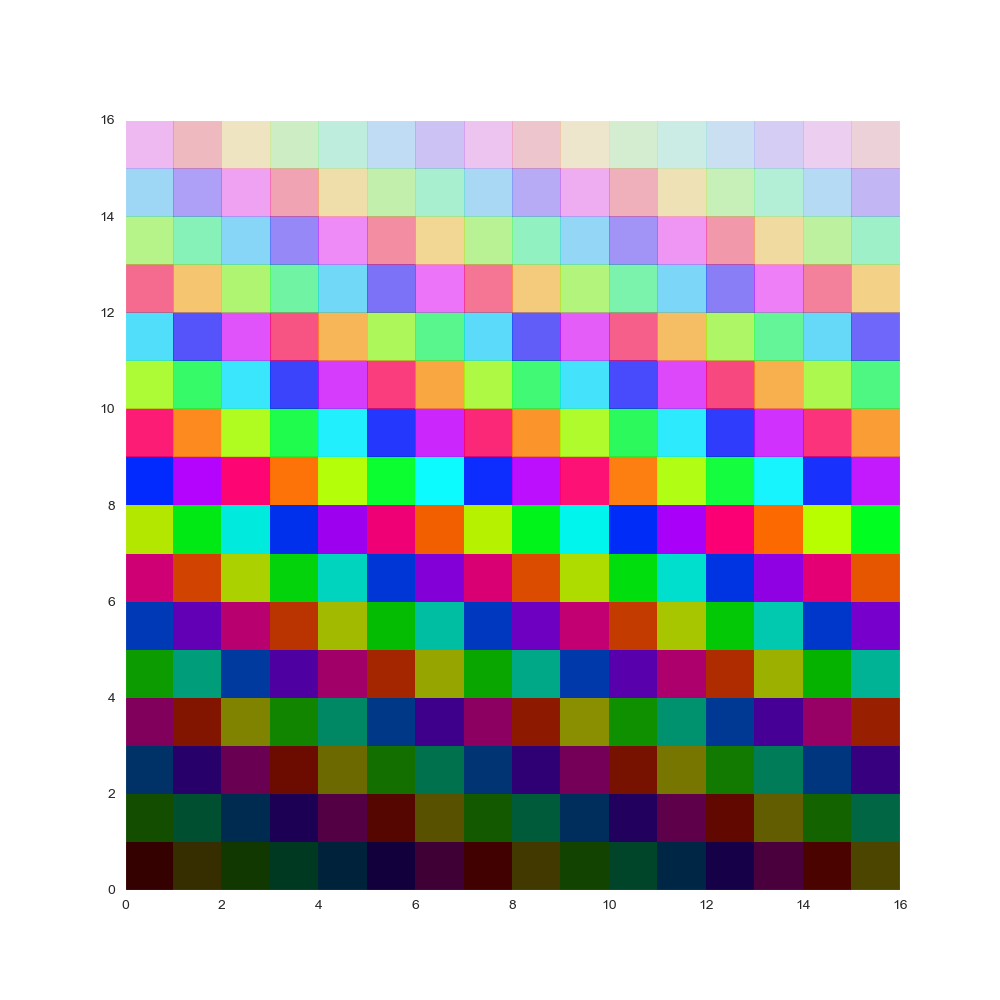

In [4]:
from matplotlib.colors import ListedColormap

plt.switch_backend('nbAgg')

N = 16
H = np.arange(N*N).reshape([N,N])
fig = plt.figure(figsize=(10, 10))
ax = plt.pcolor(H, cmap=ListedColormap(generate_colormap(N*N)))